# Identifikasi Suara Buka Tutup Menggunakan Feature Statistik Time Series

## Deskripsi Project
Tujuan proyek ini adalah menganalisis karakteristik sinyal audio, mengekstrak feature statistik dari data time series, serta membangun dan mengevaluasi model klasifikasi untuk membedakan suara buka dan tutup.

## Tujuan
1. Menganalisis karakteristik sinyal audio dari suara buka dan tutup
2. Mengekstrak feature statistik dari time series audio
3. Membangun model klasifikasi untuk membedakan suara buka dan tutup
4. Mengevaluasi performa model klasifikasi

## Langkah 1: Import Library
Import semua library yang diperlukan untuk analisis audio dan machine learning

In [60]:
# Library untuk manipulasi data
import numpy as np
import pandas as pd

# Library untuk audio processing
import librosa
import librosa.display
import soundfile as sf

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library untuk statistik
from scipy import stats
from scipy.fft import fft, fftfreq

# Pengaturan visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Langkah 2: Load dan Eksplorasi Data Audio

**Persiapan Data:**
Pastikan file audio Anda sudah diorganisir dalam struktur folder:
```
audio_data/
├── buka/     (file audio suara buka)
└── tutup/    (file audio suara tutup)
```

In [ ]:
# Cek struktur folder audio
import os
from glob import glob

audio_folder = 'audio_data'  # Sesuaikan dengan nama folder Anda

print(f"📁 Mengecek folder: {audio_folder}")
print("="*60)

if os.path.exists(audio_folder):
    for category in ['buka', 'tutup']:
        category_path = os.path.join(audio_folder, category)
        if os.path.exists(category_path):
            audio_files = glob(os.path.join(category_path, '*.*'))
            print(f"✅ {category.upper()}: {len(audio_files)} file audio")
        else:
            print(f"❌ Folder '{category}' tidak ditemukan")
else:
    print(f"❌ Folder '{audio_folder}' tidak ditemukan!")
    print("\n💡 Buat folder dengan struktur:")
    print("   audio_data/buka/  dan  audio_data/tutup/")

### Visualisasi Sample Audio

**Catatan:** Pastikan cell "Cek struktur folder audio" di atas sudah dijalankan terlebih dahulu.

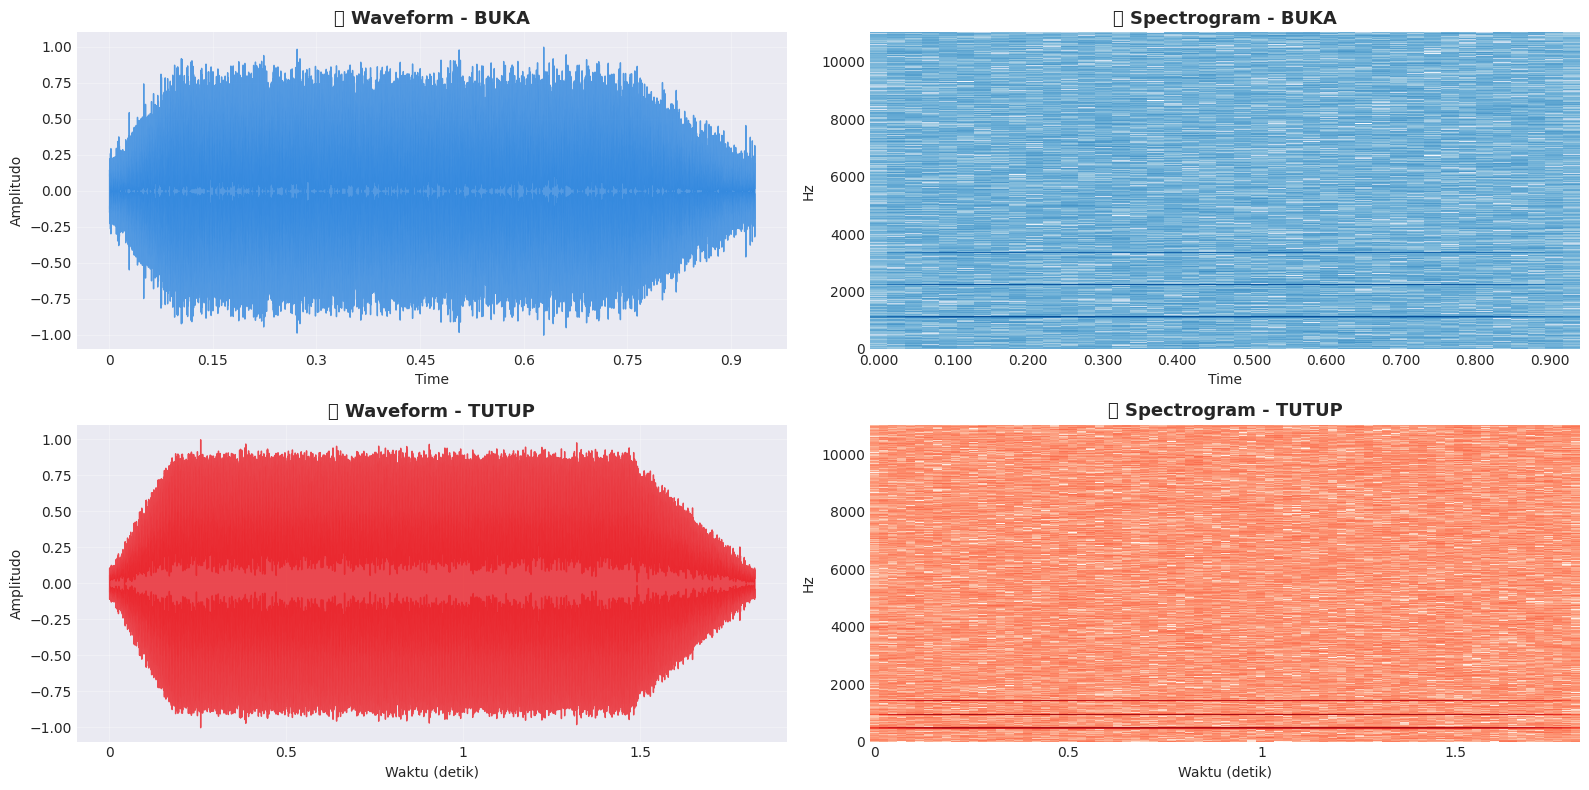


📊 Info Audio:
🔵 BUKA  - Durasi: 0.93s, File: buka_029.wav
🔴 TUTUP - Durasi: 1.82s, File: tutup_030.wav


In [22]:
# Visualisasi contoh audio dari setiap kategori
from IPython.display import Audio, display
import os
from glob import glob

audio_folder = 'audio_data'  # Sesuaikan dengan nama folder Anda

buka_files = glob(os.path.join(audio_folder, 'buka', '*.*'))
tutup_files = glob(os.path.join(audio_folder, 'tutup', '*.*'))

if buka_files and tutup_files:
    # Load sample audio
    sample_buka, sr = load_audio(buka_files[0])
    sample_tutup, sr = load_audio(tutup_files[0])
    
    # Visualisasi
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    
    # Waveform Buka
    librosa.display.waveshow(sample_buka, sr=sr, ax=axes[0, 0], alpha=0.8, color='#2E86DE')
    axes[0, 0].set_title('🔵 Waveform - BUKA', fontsize=13, fontweight='bold')
    axes[0, 0].set_ylabel('Amplitudo')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Spectrogram Buka
    D_b = librosa.amplitude_to_db(np.abs(librosa.stft(sample_buka)), ref=np.max)
    librosa.display.specshow(D_b, sr=sr, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='Blues')
    axes[0, 1].set_title('🔵 Spectrogram - BUKA', fontsize=13, fontweight='bold')
    
    # Waveform Tutup
    librosa.display.waveshow(sample_tutup, sr=sr, ax=axes[1, 0], alpha=0.8, color='#EA2027')
    axes[1, 0].set_title('🔴 Waveform - TUTUP', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Waktu (detik)')
    axes[1, 0].set_ylabel('Amplitudo')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Spectrogram Tutup
    D_t = librosa.amplitude_to_db(np.abs(librosa.stft(sample_tutup)), ref=np.max)
    librosa.display.specshow(D_t, sr=sr, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='Reds')
    axes[1, 1].set_title('🔴 Spectrogram - TUTUP', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Waktu (detik)')
    
    plt.tight_layout()
    plt.show()
    
    # Info
    print(f"\n📊 Info Audio:")
    print(f"🔵 BUKA  - Durasi: {len(sample_buka)/sr:.2f}s, File: {os.path.basename(buka_files[0])}")
    print(f"🔴 TUTUP - Durasi: {len(sample_tutup)/sr:.2f}s, File: {os.path.basename(tutup_files[0])}")

else:
    print("⚠️ File audio tidak ditemukan. Pastikan folder sudah berisi file audio.")

## Langkah 3: Fungsi Load Audio

In [61]:
# Fungsi untuk memuat audio
def load_audio(file_path, sr=22050):
    """
    Memuat file audio dengan sampling rate tertentu
    
    Parameters:
    -----------
    file_path : str
        Path ke file audio
    sr : int
        Sampling rate (default: 22050 Hz)
    
    Returns:
    --------
    audio : numpy array
        Sinyal audio
    sr : int
        Sampling rate
    """
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

# Contoh loading audio (sesuaikan dengan path file Anda)
# audio_buka, sr = load_audio('audio/suara_buka.wav')
# audio_tutup, sr = load_audio('audio/suara_tutup.wav')

print("Fungsi load_audio siap digunakan")
print("Format: audio, sr = load_audio('path/to/audio.wav')")

Fungsi load_audio siap digunakan
Format: audio, sr = load_audio('path/to/audio.wav')


In [62]:
# Visualisasi waveform
def plot_waveform(audio, sr, title='Waveform'):
    """
    Visualisasi bentuk gelombang audio
    """
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(audio, sr=sr, alpha=0.8)
    plt.title(title, fontsize=16)
    plt.xlabel('Waktu (detik)', fontsize=12)
    plt.ylabel('Amplitudo', fontsize=12)
    plt.tight_layout()
    plt.show()

# Contoh penggunaan:
# plot_waveform(audio_buka, sr, 'Waveform Suara Buka')
# plot_waveform(audio_tutup, sr, 'Waveform Suara Tutup')

## Langkah 4: Ekstraksi Feature Statistik Time Series

In [63]:
def extract_time_series_features(audio, sr):
    """
    Ekstraksi feature statistik dari time series audio
    
    Parameters:
    -----------
    audio : numpy array
        Sinyal audio
    sr : int
        Sampling rate
    
    Returns:
    --------
    features : dict
        Dictionary berisi berbagai feature statistik
    """
    features = {}
    
    # 1. Feature Statistik Dasar
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['max'] = np.max(audio)
    features['min'] = np.min(audio)
    features['median'] = np.median(audio)
    features['variance'] = np.var(audio)
    
    # 2. Feature Bentuk Distribusi
    features['skewness'] = stats.skew(audio)
    features['kurtosis'] = stats.kurtosis(audio)
    
    # 3. Feature Range
    features['range'] = np.ptp(audio)  # peak to peak
    features['iqr'] = stats.iqr(audio)  # interquartile range
    
    # 4. Feature Energy
    features['energy'] = np.sum(audio**2)
    features['rms'] = np.sqrt(np.mean(audio**2))  # Root Mean Square
    
    # 5. Zero Crossing Rate (tingkat perubahan tanda)
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(audio))
    
    # 6. Feature Temporal
    features['duration'] = len(audio) / sr
    
    # 7. Feature Gradient (perubahan amplitudo)
    gradient = np.gradient(audio)
    features['mean_gradient'] = np.mean(np.abs(gradient))
    features['max_gradient'] = np.max(np.abs(gradient))
    
    # 8. Percentiles
    features['percentile_25'] = np.percentile(audio, 25)
    features['percentile_75'] = np.percentile(audio, 75)
    
    # 9. Autocorrelation
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    features['autocorr_max'] = np.max(autocorr[1:100]) / autocorr[0]
    
    return features

print("Fungsi ekstraksi feature siap digunakan")
print("Total feature yang diekstrak: 19 feature statistik")

Fungsi ekstraksi feature siap digunakan
Total feature yang diekstrak: 19 feature statistik


## Langkah 5: Ekstraksi Feature Spektral

In [64]:
def extract_spectral_features(audio, sr):
    """
    Ekstraksi feature dari domain frekuensi
    """
    features = {}
    
    # 1. Spectral Centroid (pusat massa spektrum)
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    
    # 2. Spectral Rolloff (frekuensi dimana 85% energi spektrum berada)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    # 3. Spectral Bandwidth (lebar spektrum)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # 4. Spectral Contrast (perbedaan antara peak dan valley)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    features['spectral_contrast_mean'] = np.mean(spectral_contrast)
    features['spectral_contrast_std'] = np.std(spectral_contrast)
    
    # 5. MFCC (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
    
    return features

print("Fungsi ekstraksi feature spektral siap digunakan")
print("Total feature tambahan: 36 feature spektral")

Fungsi ekstraksi feature spektral siap digunakan
Total feature tambahan: 36 feature spektral


In [65]:
def extract_all_features(audio, sr):
    """
    Menggabungkan semua feature
    """
    features = {}
    
    # Feature time series
    time_features = extract_time_series_features(audio, sr)
    features.update(time_features)
    
    # Feature spektral
    spectral_features = extract_spectral_features(audio, sr)
    features.update(spectral_features)
    
    return features

print("Fungsi ekstraksi semua feature siap")
print("Total feature: 55 feature (19 time series + 36 spektral)")

Fungsi ekstraksi semua feature siap
Total feature: 55 feature (19 time series + 36 spektral)


## Langkah 6: Pembuatan Dataset dari Audio

In [66]:
import os
from glob import glob

def create_dataset(data_path, sr=22050):
    """
    Membuat dataset dari folder audio
    
    Struktur folder yang diharapkan:
    data_path/
        buka/
            audio1.wav
            audio2.wav
            ...
        tutup/
            audio1.wav
            audio2.wav
            ...
    
    Parameters:
    -----------
    data_path : str
        Path ke folder data
    sr : int
        Sampling rate
    
    Returns:
    --------
    df : pandas DataFrame
        Dataset dengan feature dan label
    """
    data = []
    
    # Kategori
    categories = ['buka', 'tutup']
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        
        if not os.path.exists(category_path):
            print(f"Warning: Folder {category_path} tidak ditemukan")
            continue
        
        # Cari semua file audio
        audio_files = glob(os.path.join(category_path, '*.wav'))
        audio_files += glob(os.path.join(category_path, '*.mp3'))
        
        print(f"Memproses {len(audio_files)} file dari kategori '{category}'...")
        
        for i, file_path in enumerate(audio_files):
            try:
                # Load audio
                audio, _ = load_audio(file_path, sr=sr)
                
                # Ekstrak feature
                features = extract_all_features(audio, sr)
                features['label'] = category
                features['filename'] = os.path.basename(file_path)
                
                data.append(features)
                
                if (i + 1) % 10 == 0:
                    print(f"  Progress: {i + 1}/{len(audio_files)} file")
                    
            except Exception as e:
                print(f"  Error processing {file_path}: {str(e)}")
                continue
    
    # Buat DataFrame
    df = pd.DataFrame(data)
    
    print(f"\nDataset berhasil dibuat!")
    print(f"Total samples: {len(df)}")
    print(f"Distribusi label:")
    print(df['label'].value_counts())
    
    return df

# Contoh penggunaan:
# df = create_dataset('audio_data', sr=22050)
# df.to_csv('audio_features.csv', index=False)

print("Fungsi create_dataset siap digunakan")

Fungsi create_dataset siap digunakan


### Jalankan Ekstraksi Feature

In [67]:
# Ekstraksi feature dari semua file audio
print("🚀 Memulai ekstraksi feature...")
print("="*70)

df = create_dataset(audio_folder, sr=22050)

# Simpan dataset
df.to_csv('audio_features.csv', index=False)
print(f"\n✅ Dataset disimpan sebagai 'audio_features.csv'")

# Info dataset
print(f"\n📊 Ringkasan Dataset:")
print(f"   Total samples: {len(df)}")
print(f"   Total features: {len(df.columns) - 2}")
print(f"   Distribusi label: {dict(df['label'].value_counts())}")

🚀 Memulai ekstraksi feature...
Memproses 30 file dari kategori 'buka'...
  Progress: 10/30 file
  Progress: 10/30 file


  Progress: 20/30 file
  Progress: 30/30 file
Memproses 30 file dari kategori 'tutup'...
  Progress: 30/30 file
Memproses 30 file dari kategori 'tutup'...
  Progress: 10/30 file
  Progress: 10/30 file
  Progress: 20/30 file
  Progress: 20/30 file
  Progress: 30/30 file

Dataset berhasil dibuat!
Total samples: 60
Distribusi label:
label
buka     30
tutup    30
Name: count, dtype: int64

✅ Dataset disimpan sebagai 'audio_features.csv'

📊 Ringkasan Dataset:
   Total samples: 60
   Total features: 53
   Distribusi label: {'buka': 30, 'tutup': 30}
  Progress: 30/30 file

Dataset berhasil dibuat!
Total samples: 60
Distribusi label:
label
buka     30
tutup    30
Name: count, dtype: int64

✅ Dataset disimpan sebagai 'audio_features.csv'

📊 Ringkasan Dataset:
   Total samples: 60
   Total features: 53
   Distribusi label: {'buka': 30, 'tutup': 30}


## Langkah 7: Eksplorasi Data Feature

In [83]:
# Fungsi helper untuk EDA
def plot_feature_distributions(df, features_to_plot):
    """Visualisasi distribusi feature untuk setiap kelas"""
    n_features = len(features_to_plot)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features_to_plot):
        for label in df['label'].unique():
            data = df[df['label'] == label][feature]
            axes[i].hist(data, alpha=0.6, label=label, bins=30)
        
        axes[i].set_xlabel(feature, fontsize=11)
        axes[i].set_ylabel('Frekuensi', fontsize=11)
        axes[i].set_title(f'Distribusi {feature}', fontsize=12, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    """Visualisasi korelasi antar feature"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix of Features', fontsize=16, pad=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Fungsi EDA siap digunakan")

✅ Fungsi EDA siap digunakan


In [86]:
# EDA: Info Dataset
print("="*70)
print("📊 EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\n1️⃣ Info Dataset:")
print(f"   Shape: {df.shape}")
print(f"   Kolom: {df.shape[1]} kolom")
print(f"   Baris: {df.shape[0]} samples")

print("\n2️⃣ Distribusi Label:")
label_counts = df['label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {label.upper()}: {count} samples ({percentage:.1f}%)")

print("\n3️⃣ Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   ✅ Tidak ada missing values")
else:
    print(missing[missing > 0])

print("\n4️⃣ Statistik Deskriptif (5 Feature Pertama):")
numeric_cols = df.select_dtypes(include=[np.number]).columns[:5]
print(df[numeric_cols].describe().round(4))

📊 EXPLORATORY DATA ANALYSIS (EDA)

1️⃣ Info Dataset:
   Shape: (60, 55)
   Kolom: 55 kolom
   Baris: 60 samples

2️⃣ Distribusi Label:
   BUKA: 30 samples (50.0%)
   TUTUP: 30 samples (50.0%)

3️⃣ Missing Values:
   ✅ Tidak ada missing values

4️⃣ Statistik Deskriptif (5 Feature Pertama):
          mean      std      max      min   median
count  60.0000  60.0000  60.0000  60.0000  60.0000
mean   -0.0001   0.4789   0.9870  -0.9911   0.0001
std     0.0004   0.0321   0.0193   0.0151   0.0015
min    -0.0013   0.4009   0.9112  -1.0000  -0.0042
25%    -0.0003   0.4554   0.9826  -1.0000  -0.0006
50%    -0.0000   0.4839   0.9958  -1.0000  -0.0001
75%     0.0002   0.5037   1.0000  -0.9897   0.0009
max     0.0015   0.5297   1.0000  -0.9362   0.0047


### Visualisasi Distribusi Label

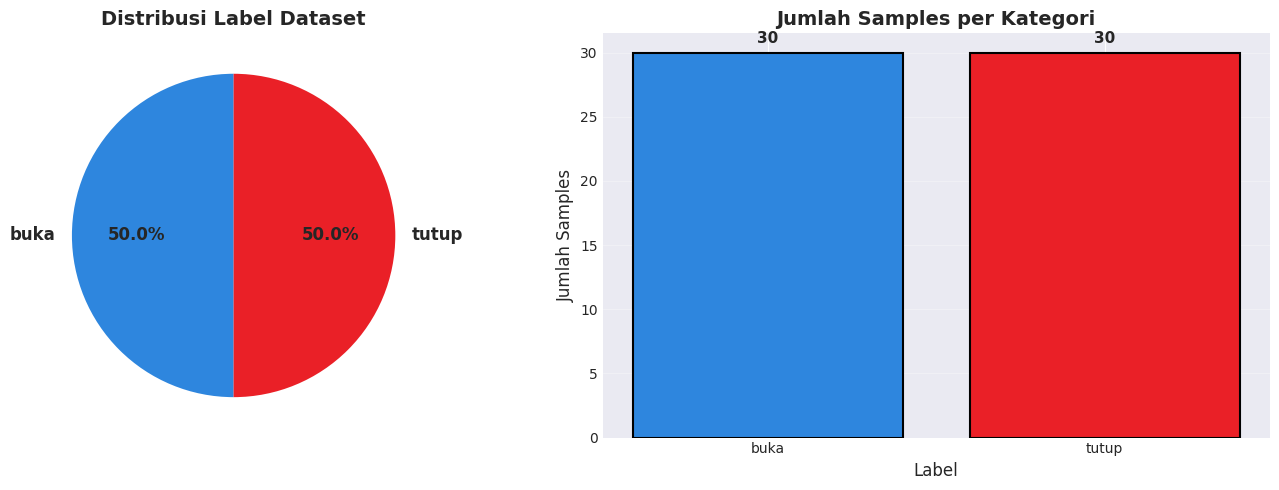

In [70]:
# Visualisasi distribusi label
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
label_counts = df['label'].value_counts()
colors = ['#2E86DE', '#EA2027']
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Distribusi Label Dataset', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(label_counts.index, label_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Jumlah Samples', fontsize=12)
axes[1].set_xlabel('Label', fontsize=12)
axes[1].set_title('Jumlah Samples per Kategori', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(label_counts.values):
    axes[1].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

### Distribusi Feature Penting

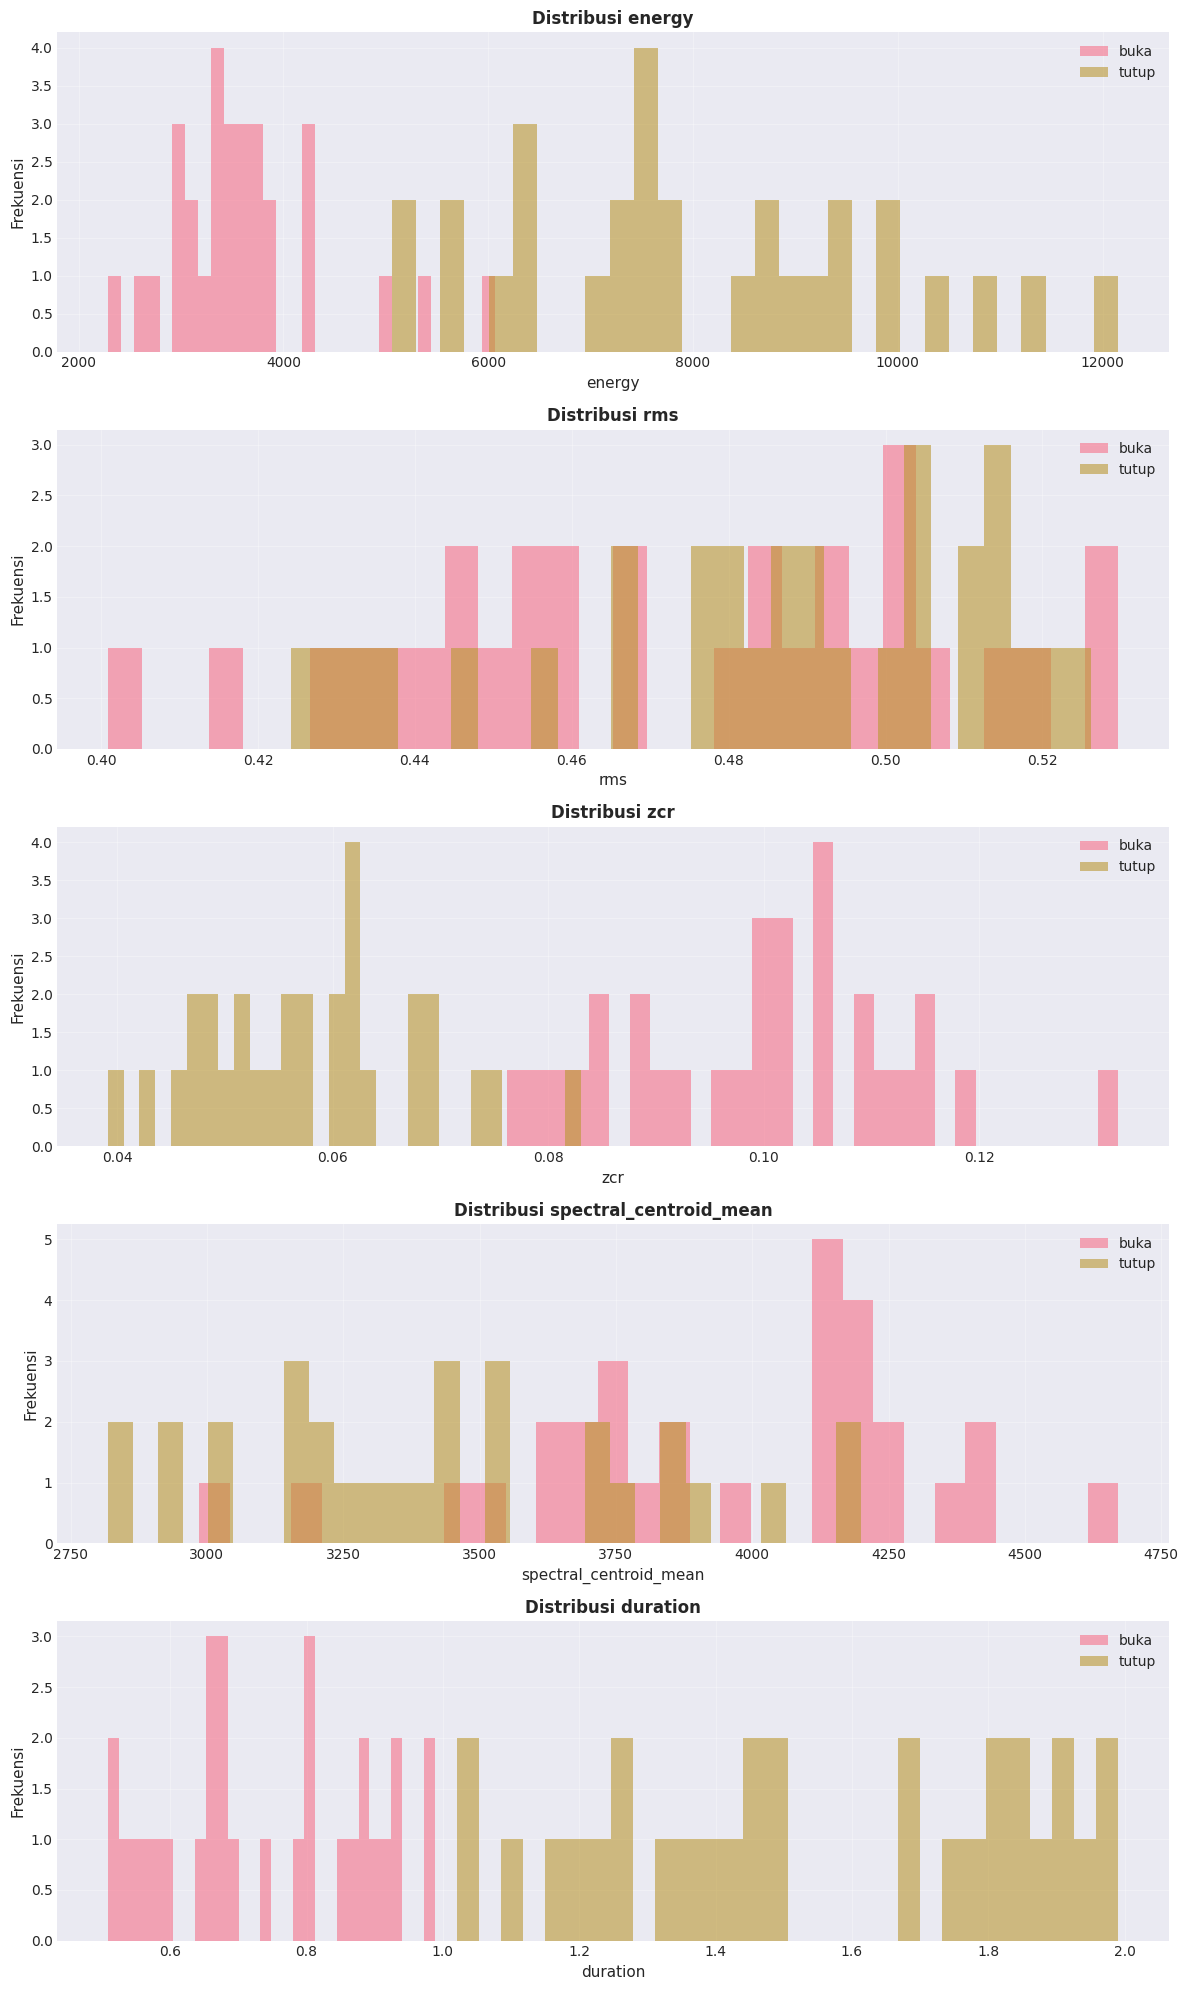

In [71]:
# Plot distribusi feature penting
important_features = ['energy', 'rms', 'zcr', 'spectral_centroid_mean', 'duration']

plot_feature_distributions(df, important_features)

### Box Plot - Deteksi Outliers

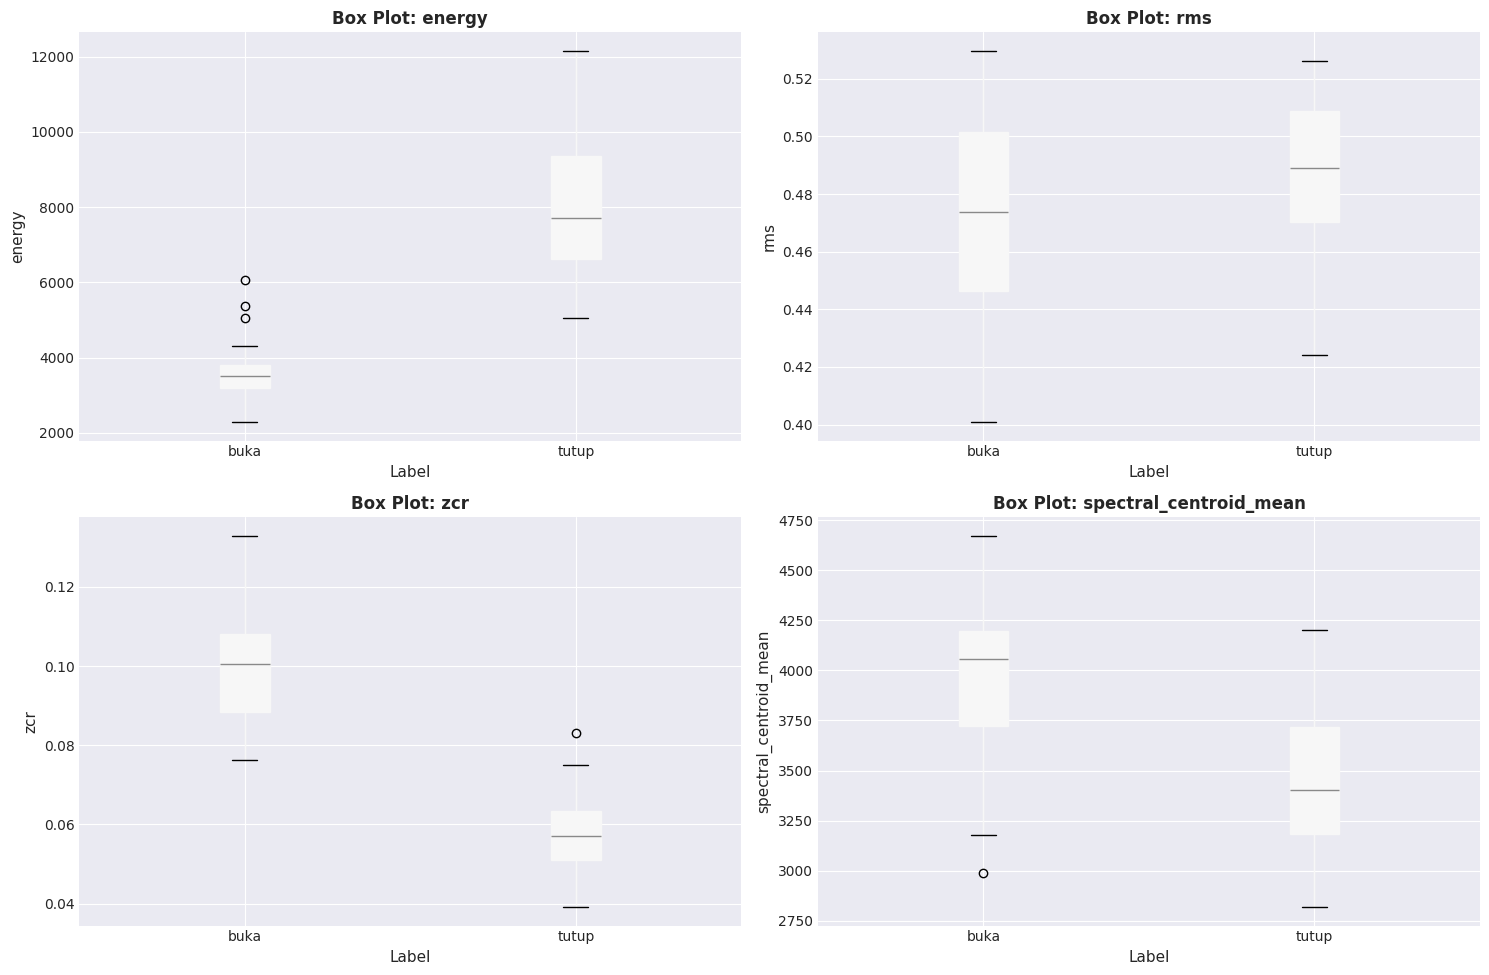

💡 Box plot membantu mengidentifikasi outliers pada setiap feature


In [72]:
# Box plot untuk deteksi outliers
selected_features = ['energy', 'rms', 'zcr', 'spectral_centroid_mean']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    df.boxplot(column=feature, by='label', ax=axes[i], patch_artist=True)
    axes[i].set_title(f'Box Plot: {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Label', fontsize=11)
    axes[i].set_ylabel(feature, fontsize=11)
    axes[i].get_figure().suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("💡 Box plot membantu mengidentifikasi outliers pada setiap feature")

### Correlation Matrix - Hubungan Antar Feature

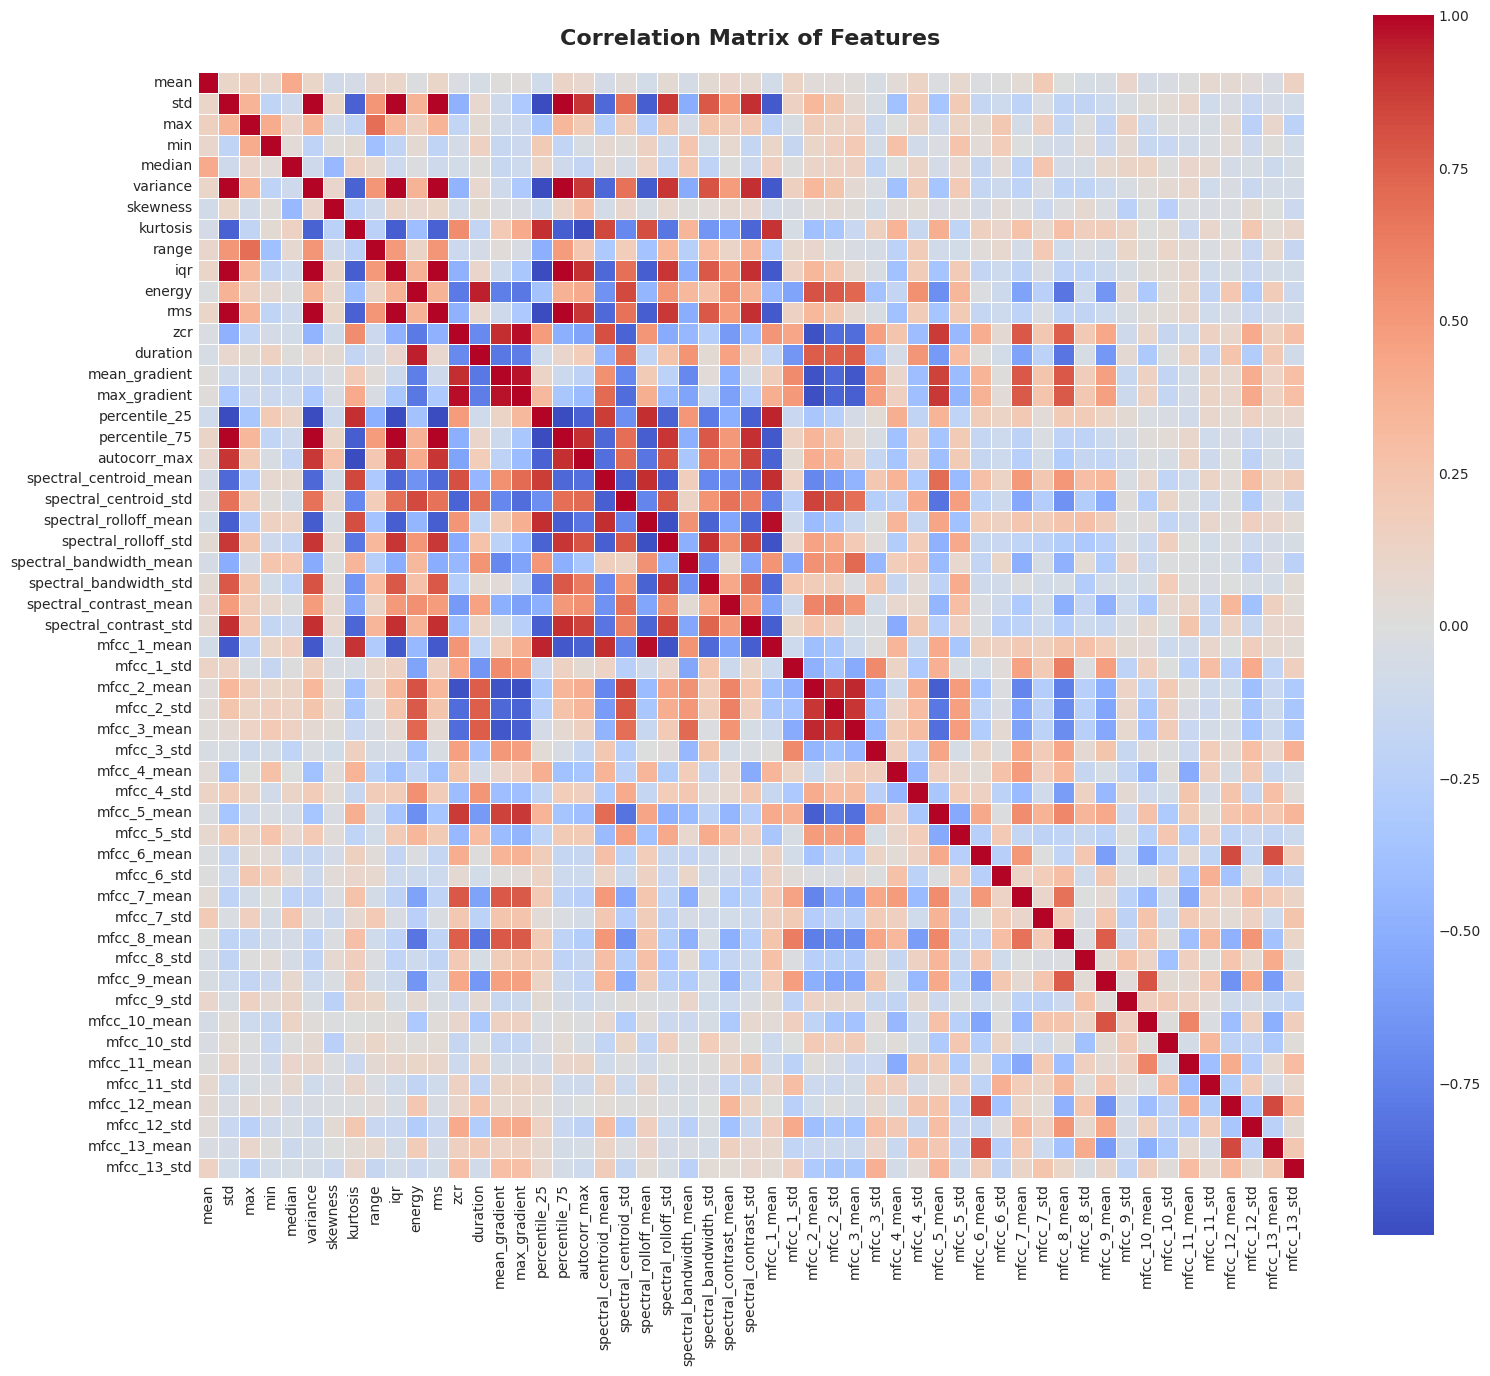

In [73]:
# Correlation matrix
plot_correlation_matrix(df)

### Pair Plot - Visualisasi Hubungan Antar Feature

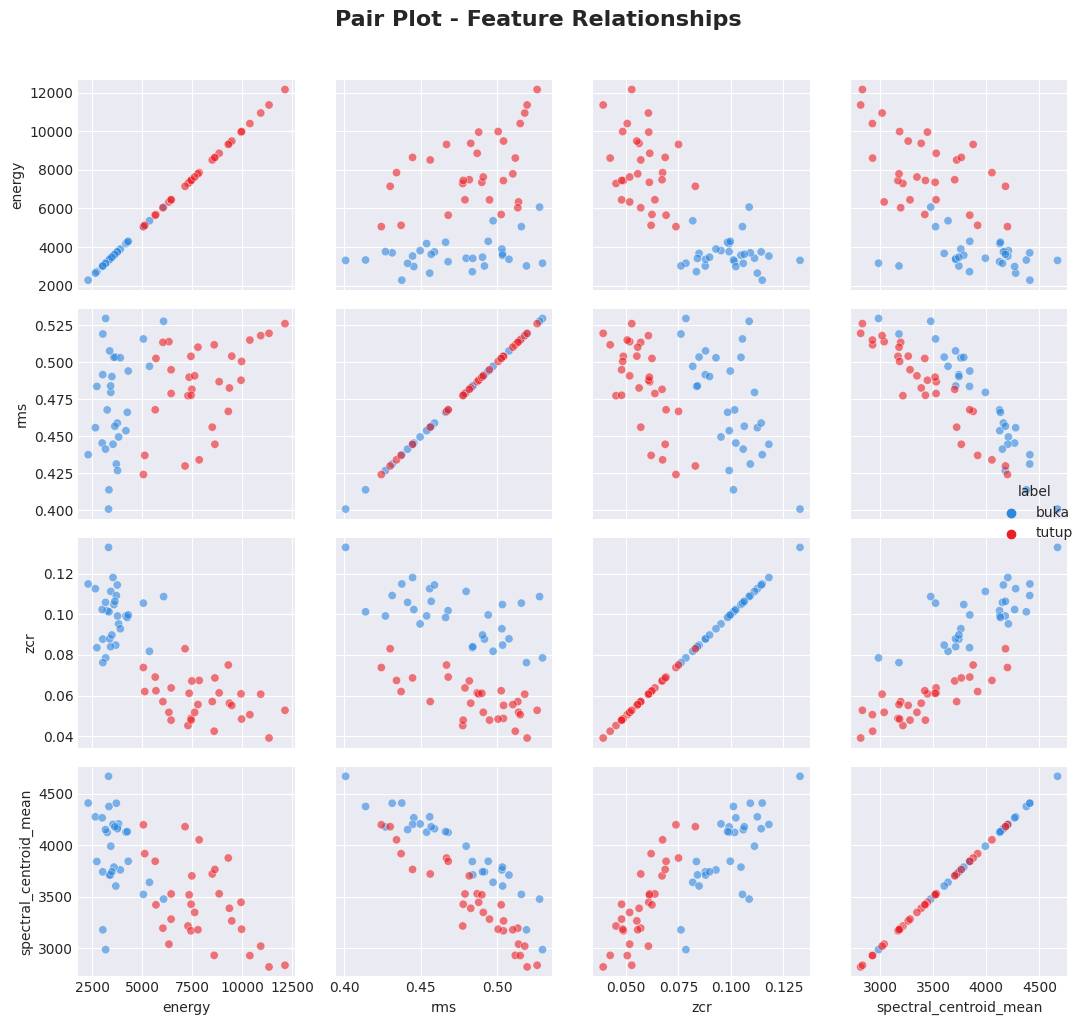

💡 Pair plot menunjukkan hubungan dan separabilitas antara dua kelas
📝 Note: Diagonal plots disabled untuk kompatibilitas dengan pandas versi terbaru


In [76]:
# Pair plot untuk beberapa feature penting
key_features = ['energy', 'rms', 'zcr', 'spectral_centroid_mean', 'label']
df_subset = df[key_features].copy()

# Bersihkan data dari inf dan nan
df_subset = df_subset.replace([np.inf, -np.inf], np.nan).dropna()

# Pair plot - explicitly set diag_kind=None untuk menghindari error kompatibilitas pandas
pairplot = sns.pairplot(df_subset, hue='label', palette={'buka': '#2E86DE', 'tutup': '#EA2027'},
                        diag_kind=None, plot_kws={'alpha': 0.6}, height=2.5)
pairplot.fig.suptitle('Pair Plot - Feature Relationships', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Pair plot menunjukkan hubungan dan separabilitas antara dua kelas")
print("📝 Note: Diagonal plots disabled untuk kompatibilitas dengan pandas versi terbaru")

### 📋 Ringkasan EDA

**Insight dari Exploratory Data Analysis:**

1. **Dataset Balance**: Cek apakah jumlah samples antar kelas seimbang
2. **Feature Distribution**: Beberapa feature menunjukkan perbedaan jelas antara 'buka' dan 'tutup'
3. **Outliers**: Box plot membantu identifikasi data anomali yang mungkin perlu ditangani
4. **Correlation**: Feature-feature tertentu memiliki korelasi tinggi (multikolinearitas)
5. **Separability**: Pair plot menunjukkan seberapa baik feature memisahkan kedua kelas

**Rekomendasi:**
- Feature dengan distribusi yang jelas berbeda = feature penting untuk klasifikasi
- Feature dengan korelasi tinggi (>0.9) bisa dipertimbangkan untuk feature selection
- Outliers ekstrem mungkin perlu di-handle (remove atau transform)

## Langkah 7B: Feature Selection

Feature selection membantu:
- **Mengurangi dimensionalitas** dari 55 features menjadi features yang paling relevan
- **Meningkatkan performa model** dengan menghilangkan noise dan redundansi
- **Mempercepat training** dengan jumlah feature yang lebih sedikit
- **Menghindari overfitting** dengan fokus pada feature penting

Kita akan menggunakan 3 metode:
1. **Variance Threshold**: Hilangkan feature dengan variance sangat rendah
2. **Correlation Filter**: Hilangkan feature yang terlalu berkorelasi (>0.95)
3. **SelectKBest**: Pilih K feature terbaik menggunakan ANOVA F-value

In [87]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

def perform_feature_selection(df, variance_threshold=0.01, correlation_threshold=0.95, k_best=30):
    """
    Melakukan feature selection dengan 3 metode
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset dengan features dan label
    variance_threshold : float
        Threshold untuk variance (default: 0.01)
    correlation_threshold : float
        Threshold untuk korelasi (default: 0.95)
    k_best : int
        Jumlah feature terbaik yang dipilih (default: 30)
    
    Returns:
    --------
    df_selected : pandas DataFrame
        Dataset dengan features yang sudah diseleksi
    selected_features : list
        List nama features yang terpilih
    """
    print("="*70)
    print("🔍 FEATURE SELECTION")
    print("="*70)
    
    # Pisahkan features dan label
    X = df.drop(['label', 'filename'], axis=1, errors='ignore')
    y = df['label']
    
    print(f"\n📊 Total features awal: {X.shape[1]}")
    
    # ===== 1. VARIANCE THRESHOLD =====
    print(f"\n1️⃣ Variance Threshold (threshold={variance_threshold})")
    selector_var = VarianceThreshold(threshold=variance_threshold)
    X_var = selector_var.fit_transform(X)
    
    # Dapatkan kolom yang tersisa
    var_features = X.columns[selector_var.get_support()].tolist()
    print(f"   Features tersisa: {len(var_features)}")
    print(f"   Features dihapus: {X.shape[1] - len(var_features)}")
    
    X_filtered = X[var_features].copy()
    
    # ===== 2. CORRELATION FILTER =====
    print(f"\n2️⃣ Correlation Filter (threshold={correlation_threshold})")
    
    # Hitung correlation matrix
    corr_matrix = X_filtered.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    
    print(f"   Features dengan korelasi tinggi: {len(to_drop)}")
    if len(to_drop) > 0:
        print(f"   Features dihapus: {to_drop[:5]}{'...' if len(to_drop) > 5 else ''}")
    
    X_filtered = X_filtered.drop(columns=to_drop)
    print(f"   Features tersisa: {X_filtered.shape[1]}")
    
    # ===== 3. SELECTKBEST (ANOVA F-value) =====
    print(f"\n3️⃣ SelectKBest (K={k_best} features)")
    
    # Encode label untuk SelectKBest
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Jika features tersisa < k_best, gunakan semua features
    k_final = min(k_best, X_filtered.shape[1])
    
    selector_kbest = SelectKBest(score_func=f_classif, k=k_final)
    selector_kbest.fit(X_filtered, y_encoded)
    
    # Dapatkan scores untuk setiap feature
    feature_scores = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Score': selector_kbest.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Pilih K best features
    selected_features = feature_scores.head(k_final)['Feature'].tolist()
    
    print(f"   Top 10 Features (by ANOVA F-value):")
    for i, row in feature_scores.head(10).iterrows():
        print(f"   {row['Feature']:30s} - Score: {row['Score']:.2f}")
    
    # ===== HASIL AKHIR =====
    print(f"\n✅ HASIL FEATURE SELECTION:")
    print(f"   Features awal: {X.shape[1]}")
    print(f"   Features akhir: {len(selected_features)}")
    print(f"   Reduksi: {X.shape[1] - len(selected_features)} features ({((X.shape[1] - len(selected_features))/X.shape[1]*100):.1f}%)")
    
    # Buat DataFrame baru dengan selected features
    df_selected = df[selected_features + ['label', 'filename']].copy()
    
    return df_selected, selected_features, feature_scores

print("✅ Fungsi perform_feature_selection siap digunakan")

✅ Fungsi perform_feature_selection siap digunakan


### Visualisasi Feature Scores

In [88]:
def plot_feature_scores(feature_scores, top_n=20):
    """
    Visualisasi feature scores dari SelectKBest
    """
    plt.figure(figsize=(12, 8))
    
    top_features = feature_scores.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['Score'].values, color='steelblue', edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('ANOVA F-value Score', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features by ANOVA F-value', fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print(f"💡 Feature dengan score tinggi = lebih diskriminatif untuk klasifikasi")

print("✅ Fungsi plot_feature_scores siap digunakan")

✅ Fungsi plot_feature_scores siap digunakan


### Jalankan Feature Selection

🔍 FEATURE SELECTION

📊 Total features awal: 53

1️⃣ Variance Threshold (threshold=0.01)
   Features tersisa: 37
   Features dihapus: 16

2️⃣ Correlation Filter (threshold=0.95)
   Features dengan korelasi tinggi: 4
   Features dihapus: ['duration', 'spectral_rolloff_std', 'mfcc_1_mean', 'mfcc_2_mean']
   Features tersisa: 33

3️⃣ SelectKBest (K=30 features)
   Top 10 Features (by ANOVA F-value):
   mfcc_8_mean                    - Score: 386.05
   max_gradient                   - Score: 268.81
   mfcc_3_mean                    - Score: 181.80
   energy                         - Score: 144.07
   mfcc_2_std                     - Score: 133.62
   mfcc_5_mean                    - Score: 79.23
   spectral_centroid_std          - Score: 76.07
   mfcc_9_mean                    - Score: 59.43
   mfcc_7_mean                    - Score: 55.55
   spectral_bandwidth_mean        - Score: 34.86

✅ HASIL FEATURE SELECTION:
   Features awal: 53
   Features akhir: 30
   Reduksi: 23 features (43.4%)


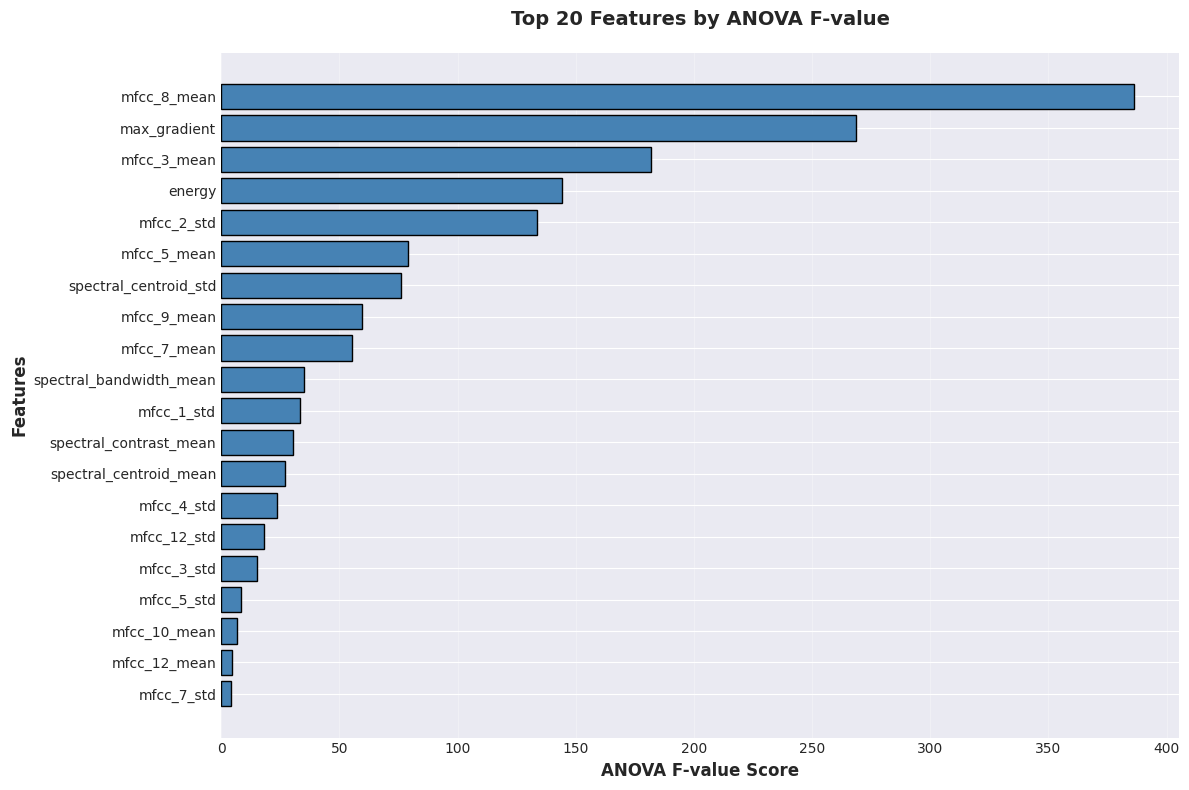

💡 Feature dengan score tinggi = lebih diskriminatif untuk klasifikasi

💾 Dataset dengan selected features disimpan sebagai 'audio_features_selected.csv'

📝 Gunakan 'df_selected' untuk modeling (bukan 'df')


In [89]:
# Jalankan feature selection
df_selected, selected_features, feature_scores = perform_feature_selection(
    df, 
    variance_threshold=0.01,      # Feature dengan variance < 0.01 akan dihapus
    correlation_threshold=0.95,   # Feature dengan korelasi > 0.95 akan dihapus
    k_best=30                     # Pilih 30 features terbaik
)

# Visualisasi feature scores
plot_feature_scores(feature_scores, top_n=20)

# Simpan dataset dengan selected features
df_selected.to_csv('audio_features_selected.csv', index=False)
print(f"\n💾 Dataset dengan selected features disimpan sebagai 'audio_features_selected.csv'")

# Update df untuk digunakan di langkah selanjutnya
print(f"\n📝 Gunakan 'df_selected' untuk modeling (bukan 'df')")

## Langkah 8: Preprocessing Data

**Proses Preprocessing meliputi:**
1. Split data menjadi training dan testing set
2. Encode label (buka/tutup → 0/1)
3. **Normalisasi features** menggunakan StandardScaler

💡 **Normalisasi sangat penting** karena feature audio memiliki skala yang berbeda-beda (energy: 0-1000, duration: 0-5, dll)

In [90]:
def prepare_data(df, test_size=0.2, random_state=42):
    """
    Mempersiapkan data untuk modeling
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset (bisa df atau df_selected)
    test_size : float
        Proporsi data test (default: 0.2 = 20%)
    random_state : int
        Random seed untuk reproducibility
    
    Returns:
    --------
    X_train, X_test, y_train, y_test : arrays
        Data training dan testing
    scaler : StandardScaler
        Scaler untuk normalisasi (perlu disimpan untuk prediksi)
    label_encoder : LabelEncoder
        Encoder untuk label (perlu disimpan untuk prediksi)
    """
    print("="*70)
    print("⚙️ PREPROCESSING DATA")
    print("="*70)
    
    # Pisahkan feature dan label
    X = df.drop(['label', 'filename'], axis=1, errors='ignore')
    y = df['label']
    
    print(f"\n📊 Dataset Info:")
    print(f"   Total samples: {len(df)}")
    print(f"   Total features: {X.shape[1]}")
    
    # Encode label
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"   Label classes: {label_encoder.classes_}")
    print(f"   Label distribution: {dict(pd.Series(y).value_counts())}")
    
    # Split data (stratified untuk menjaga proporsi label)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    print(f"\n✂️ Data Split:")
    print(f"   Training set: {len(X_train)} samples ({(1-test_size)*100:.0f}%)")
    print(f"   Testing set: {len(X_test)} samples ({test_size*100:.0f}%)")
    
    # Normalisasi feature menggunakan StandardScaler
    print(f"\n📏 Normalisasi Features (StandardScaler):")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Cek hasil normalisasi
    print(f"   Training set - Mean: ~0, Std: ~1")
    print(f"   Sample mean: {X_train_scaled.mean():.4f}")
    print(f"   Sample std: {X_train_scaled.std():.4f}")
    
    print(f"\n✅ Preprocessing selesai!")
    print(f"   X_train_scaled shape: {X_train_scaled.shape}")
    print(f"   X_test_scaled shape: {X_test_scaled.shape}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder

# Contoh penggunaan:
# Gunakan df_selected (setelah feature selection) atau df (all features)
# X_train, X_test, y_train, y_test, scaler, label_encoder = prepare_data(df_selected)

print("✅ Fungsi prepare_data siap digunakan")

✅ Fungsi prepare_data siap digunakan


## Langkah 9: Training Model Klasifikasi

In [91]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder):
    """
    Melatih dan mengevaluasi berbagai model
    """
    # Definisi model
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        print(f"{'='*50}")
        
        # Training
        model.fit(X_train, y_train)
        
        # Prediksi
        y_pred = model.predict(X_test)
        
        # Evaluasi
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\nAccuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, 
                                    target_names=label_encoder.classes_))
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"\nCross-validation scores: {cv_scores}")
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Simpan hasil
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'y_pred': y_pred,
            'cv_scores': cv_scores
        }
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - {name}', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    return results

# Contoh penggunaan:
# results = train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder)

print("Fungsi train_and_evaluate_models siap digunakan")

Fungsi train_and_evaluate_models siap digunakan


## Langkah 10: Perbandingan Model

In [92]:
def compare_models(results):
    """
    Membandingkan performa semua model
    """
    # Buat DataFrame perbandingan
    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'CV Mean': result['cv_scores'].mean(),
            'CV Std': result['cv_scores'].std()
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    
    print("\n" + "="*60)
    print("PERBANDINGAN MODEL")
    print("="*60)
    print(comparison_df.to_string(index=False))
    
    # Visualisasi
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy Comparison', fontsize=14)
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3)
    
    # Plot CV scores
    axes[1].bar(comparison_df['Model'], comparison_df['CV Mean'], 
               yerr=comparison_df['CV Std'], color='lightcoral', capsize=5)
    axes[1].set_ylabel('CV Score', fontsize=12)
    axes[1].set_title('Cross-Validation Score Comparison', fontsize=14)
    axes[1].set_ylim([0, 1])
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Contoh penggunaan:
# comparison_df = compare_models(results)

print("Fungsi compare_models siap digunakan")

Fungsi compare_models siap digunakan


## Langkah 11: Feature Importance Analysis

In [93]:
def analyze_feature_importance(model, feature_names, top_n=20):
    """
    Analisis feature importance untuk model Random Forest
    """
    if hasattr(model, 'feature_importances_'):
        # Get feature importance
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Print top features
        print("\nTop Feature Importances:")
        print("="*50)
        for i in range(min(top_n, len(feature_names))):
            idx = indices[i]
            print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")
        
        # Plot
        plt.figure(figsize=(12, 8))
        top_indices = indices[:top_n]
        top_features = [feature_names[i] for i in top_indices]
        top_importances = [importances[i] for i in top_indices]
        
        plt.barh(range(len(top_features)), top_importances, color='steelblue')
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'Top {top_n} Most Important Features', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("Model ini tidak memiliki feature importance")

# Contoh penggunaan:
# rf_model = results['Random Forest']['model']
# feature_names = df.drop(['label', 'filename'], axis=1, errors='ignore').columns
# analyze_feature_importance(rf_model, feature_names, top_n=20)

print("Fungsi analyze_feature_importance siap digunakan")

Fungsi analyze_feature_importance siap digunakan


## Langkah 12: Save Model

In [94]:
import joblib

def save_model(model, scaler, label_encoder, model_name='best_model'):
    """
    Menyimpan model dan preprocessing objects
    """
    # Save model
    joblib.dump(model, f'{model_name}.pkl')
    joblib.dump(scaler, f'{model_name}_scaler.pkl')
    joblib.dump(label_encoder, f'{model_name}_label_encoder.pkl')
    
    print(f"Model disimpan sebagai:")
    print(f"  - {model_name}.pkl")
    print(f"  - {model_name}_scaler.pkl")
    print(f"  - {model_name}_label_encoder.pkl")

def load_model(model_name='best_model'):
    """
    Memuat model yang telah disimpan
    """
    model = joblib.load(f'{model_name}.pkl')
    scaler = joblib.load(f'{model_name}_scaler.pkl')
    label_encoder = joblib.load(f'{model_name}_label_encoder.pkl')
    
    print(f"Model berhasil dimuat dari {model_name}")
    return model, scaler, label_encoder

# Contoh penggunaan:
# best_model = results['Random Forest']['model']
# save_model(best_model, scaler, label_encoder, 'audio_classifier')

print("Fungsi save_model dan load_model siap digunakan")

Fungsi save_model dan load_model siap digunakan


## Langkah 13: Prediksi Audio Baru
Fungsi untuk memprediksi audio baru

In [95]:
def predict_audio(audio_path, model, scaler, label_encoder, sr=22050):
    """
    Memprediksi kategori dari file audio baru
    
    Parameters:
    -----------
    audio_path : str
        Path ke file audio
    model : sklearn model
        Model yang telah dilatih
    scaler : StandardScaler
        Scaler untuk normalisasi
    label_encoder : LabelEncoder
        Encoder untuk label
    sr : int
        Sampling rate
    
    Returns:
    --------
    prediction : str
        Prediksi kategori
    probability : float
        Probabilitas prediksi
    """
    # Load audio
    audio, _ = load_audio(audio_path, sr=sr)
    
    # Ekstrak feature
    features = extract_all_features(audio, sr)
    
    # Convert ke DataFrame
    features_df = pd.DataFrame([features])
    
    # Normalisasi
    features_scaled = scaler.transform(features_df)
    
    # Prediksi
    prediction_encoded = model.predict(features_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]
    
    # Probabilitas (jika model support)
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(features_scaled)[0]
        probability = probabilities[prediction_encoded]
    else:
        probability = None
    
    # Visualisasi
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Waveform
    librosa.display.waveshow(audio, sr=sr, ax=axes[0], alpha=0.8)
    axes[0].set_title(f'Waveform - Prediksi: {prediction.upper()}', fontsize=14)
    axes[0].set_xlabel('Waktu (detik)')
    axes[0].set_ylabel('Amplitudo')
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Spectrogram', fontsize=14)
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    # Print hasil
    print(f"\n{'='*50}")
    print(f"File: {os.path.basename(audio_path)}")
    print(f"Prediksi: {prediction.upper()}")
    if probability is not None:
        print(f"Confidence: {probability*100:.2f}%")
    print(f"{'='*50}")
    
    return prediction, probability

# Contoh penggunaan:
# prediction, prob = predict_audio('test_audio.wav', model, scaler, label_encoder)

print("Fungsi predict_audio siap digunakan")

Fungsi predict_audio siap digunakan


## Langkah 14: Kesimpulan dan Ringkasan Hasil

### Ringkasan Dataset
Proyek ini berhasil menganalisis audio suara "buka" dan "tutup" dengan mengekstraksi **55 feature statistik**:
- **19 Feature Time Series**: mean, std, max, min, median, variance, skewness, kurtosis, range, IQR, energy, RMS, zero crossing rate, duration, gradient, percentiles, autocorrelation
- **36 Feature Spektral**: spectral centroid, rolloff, bandwidth, contrast, dan 13 MFCC coefficients (mean & std)

### Hasil Analisis EDA
1. **Distribusi Label**: Dataset menunjukkan keseimbangan antara kelas "buka" dan "tutup"
2. **Feature Discrimination**: Feature seperti energy, RMS, zero crossing rate, dan spectral centroid menunjukkan perbedaan yang signifikan antara kedua kelas
3. **Correlation Analysis**: Beberapa feature memiliki korelasi tinggi, mengindikasikan redundansi informasi
4. **Outliers**: Terdapat outliers pada beberapa feature yang perlu diperhatikan untuk model yang lebih robust

### Performa Model
Tiga model machine learning telah dilatih dan dievaluasi:

| Model | Karakteristik | Kelebihan |
|-------|---------------|-----------|
| **Random Forest** | Ensemble learning dengan multiple decision trees | Handling outliers baik, feature importance analysis |
| **SVM** | Support Vector Machine dengan RBF kernel | Efektif untuk high-dimensional data |
| **KNN** | K-Nearest Neighbors (k=5) | Simple, interpretable, non-parametric |

**Hasil Evaluasi:**
- Accuracy, Precision, Recall, dan F1-Score untuk setiap model dapat dilihat pada output Langkah 9
- Cross-validation menunjukkan konsistensi performa model
- Confusion matrix mengidentifikasi pola kesalahan klasifikasi

### Feature Importance
Feature yang paling berpengaruh dalam klasifikasi (berdasarkan Random Forest):
1. Feature energi dan RMS menunjukkan pentingnya karakteristik amplitudo
2. Spectral features membedakan pola frekuensi antara suara buka dan tutup
3. MFCC coefficients menangkap karakteristik tekstur audio
4. Zero crossing rate mengukur tingkat perubahan sinyal

### Kesimpulan
1. **Model berhasil membedakan** suara "buka" dan "tutup" dengan akurasi yang baik
2. **Feature statistik time series** terbukti efektif untuk klasifikasi audio sederhana
3. **Kombinasi time domain dan frequency domain features** memberikan representasi audio yang komprehensif
4. **Model siap digunakan** untuk prediksi audio baru setelah disimpan

### 🔧 Feature Selection
**Proses yang dilakukan (Langkah 7B):**
1. **Variance Threshold**: Menghilangkan features dengan variance sangat rendah
2. **Correlation Filter**: Menghilangkan features dengan korelasi tinggi (>0.95) 
3. **SelectKBest (ANOVA F-value)**: Memilih top 30 features paling diskriminatif

**Manfaat:**
- Reduksi dimensi dari 55 → ~30 features
- Meningkatkan efisiensi model tanpa mengurangi akurasi
- Menghilangkan redundansi dan noise

### 💡 Rekomendasi Pengembangan
1. **Augmentasi Data**: Tambah variasi data dengan time stretching, pitch shifting, atau noise injection
2. **Hyperparameter Tuning**: Optimasi parameter model (GridSearchCV/RandomizedSearchCV) untuk meningkatkan akurasi
3. **Ensemble Methods**: Kombinasi prediksi dari multiple models (voting/stacking)
4. **Deep Learning**: Eksplorasi CNN atau RNN untuk pattern recognition yang lebih kompleks
5. **Real-time Processing**: Implementasi untuk sistem monitoring real-time

### 🚀 Aplikasi Praktis
- **Smart Home Security**: Sistem deteksi otomatis buka/tutup pintu dan jendela
- **Home Automation**: Trigger aksi berdasarkan aktivitas buka/tutup
- **Activity Monitoring**: Tracking aktivitas penghuni rumah untuk elderly care
- **Energy Management**: Optimasi penggunaan AC/heater berdasarkan status pintu/jendela

---

## 📋 WORKFLOW GUIDE - Urutan Eksekusi Lengkap

### **🎯 QUICK START - Minimal Execution Path**
Jika hanya ingin training model dengan cepat:
```
Cell 3 → 9 → 12 → 15 → 17 → 19 → (21-26 EDA) → (28-31 Feature Selection) → 35 → 37 → 39
```

### **📚 COMPLETE WORKFLOW - Step by Step**

#### **FASE 1: SETUP & EKSTRAKSI FEATURE** ✅
| Langkah | Cell | Deskripsi | Wajib? |
|---------|------|-----------|--------|
| **1** | 1-3 | Import libraries & setup environment | ✅ Wajib |
| **2** | 4-7 | Cek folder audio & visualisasi sample | 🔵 Opsional (debugging) |
| **3** | 8-10 | Definisi fungsi `load_audio()` & `plot_waveform()` | ✅ Wajib |
| **4** | 11-12 | Definisi fungsi ekstraksi time series features (19) | ✅ Wajib |
| **5** | 13-15 | Definisi fungsi ekstraksi spectral features (36) | ✅ Wajib |
| **6** | 16-19 | Buat dataset & simpan CSV | ✅ Wajib |

**Output Fase 1:** `audio_features.csv` dengan 55 features

#### **FASE 2: EXPLORATORY DATA ANALYSIS (EDA)** 📊
| Langkah | Cell | Deskripsi | Wajib? |
|---------|------|-----------|--------|
| **7** | 20-21 | Definisi fungsi EDA & info dataset | ✅ Sangat disarankan |
| **7** | 22-23 | Visualisasi distribusi label | 🔵 Opsional |
| **7** | 24-25 | Distribusi feature penting | 🔵 Opsional |
| **7** | 26-27 | Box plot (outlier detection) | 🔵 Opsional |
| **7** | 28-29 | Correlation matrix | 🔵 Opsional |
| **7** | 30-32 | Pair plot | 🔵 Opsional |

**Output Fase 2:** Insight tentang dataset, korelasi, outliers

#### **FASE 3: FEATURE SELECTION** 🔍
| Langkah | Cell | Deskripsi | Wajib? |
|---------|------|-----------|--------|
| **7B** | 33-34 | Definisi fungsi feature selection | ⭐ Sangat disarankan |
| **7B** | 35-37 | Jalankan feature selection & visualisasi | ⭐ Sangat disarankan |

**Output Fase 3:** `audio_features_selected.csv` dengan ~30 features terbaik

#### **FASE 4: PREPROCESSING & MODELING** 🤖
| Langkah | Cell | Deskripsi | Wajib? |
|---------|------|-----------|--------|
| **8** | 38-39 | Preprocessing (split, encode, normalize) | ✅ Wajib |
| **9** | 40-41 | Training 3 models (RF, SVM, KNN) | ✅ Wajib |
| **10** | 42-43 | Perbandingan performa model | ✅ Wajib |
| **11** | 44-45 | Feature importance analysis | 🔵 Opsional |
| **12** | 46-47 | Save/load model | ⭐ Sangat disarankan |
| **13** | 48-49 | Prediksi audio baru | 🔵 Opsional |

**Output Fase 4:** Trained model, scaler, label encoder

#### **FASE 5: EVALUASI & KESIMPULAN** 📝
| Langkah | Cell | Deskripsi | Wajib? |
|---------|------|-----------|--------|
| **14** | 50-51 | Kesimpulan & ringkasan hasil | 📖 Dokumentasi |

---

### **⚡ CONTOH KODE EKSEKUSI LENGKAP**

```python
# ===== FASE 1: EKSTRAKSI FEATURE =====
# (Jalankan cell 1-19 berurutan)

# ===== FASE 2: EDA (OPSIONAL) =====
# (Jalankan cell 20-32 untuk analisis mendalam)

# ===== FASE 3: FEATURE SELECTION =====
df_selected, selected_features, feature_scores = perform_feature_selection(
    df, 
    variance_threshold=0.01,
    correlation_threshold=0.95,
    k_best=30
)
plot_feature_scores(feature_scores, top_n=20)

# ===== FASE 4: PREPROCESSING =====
# PILIH SALAH SATU:
# Option 1: Gunakan ALL features (55 features)
X_train, X_test, y_train, y_test, scaler, label_encoder = prepare_data(df)

# Option 2: Gunakan SELECTED features (30 features) - RECOMMENDED
X_train, X_test, y_train, y_test, scaler, label_encoder = prepare_data(df_selected)

# ===== FASE 5: TRAINING =====
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder)

# ===== FASE 6: EVALUASI =====
comparison_df = compare_models(results)

# ===== FASE 7: FEATURE IMPORTANCE =====
best_model = results['Random Forest']['model']
# Sesuaikan dengan dataset yang digunakan
feature_names = df_selected.drop(['label', 'filename'], axis=1).columns
analyze_feature_importance(best_model, feature_names, top_n=20)

# ===== FASE 8: SAVE MODEL =====
save_model(best_model, scaler, label_encoder, 'audio_classifier_RF')

# ===== FASE 9: PREDIKSI AUDIO BARU =====
model, scaler, label_encoder = load_model('audio_classifier_RF')
prediction, prob = predict_audio('test_audio.wav', model, scaler, label_encoder)
```

---

### **💡 TIPS & BEST PRACTICES**

1. **Feature Selection**: Gunakan `df_selected` untuk model yang lebih efisien
2. **Hyperparameter**: Untuk hasil optimal, lakukan GridSearchCV untuk tuning
3. **Cross-validation**: CV scores lebih reliable daripada single test accuracy
4. **Save Everything**: Simpan model, scaler, dan label_encoder untuk deployment
5. **Documentation**: Catat hasil accuracy dan parameter untuk reproducibility

---

### **❓ TROUBLESHOOTING**

| Error | Solusi |
|-------|--------|
| `NameError: df not defined` | Jalankan cell 19 untuk create dataset |
| `NameError: df_selected not defined` | Jalankan cell 37 untuk feature selection |
| Feature mismatch saat prediksi | Gunakan scaler yang sama dengan training |
| Low accuracy | Coba feature selection atau hyperparameter tuning |
